# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [31]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

from config_plots import global_settings
global_settings()

In [32]:
%matplotlib inline
import os
import torch

import matplotlib.pyplot as plt
import torchvision.models as models

# from flashtorch.utils import apply_transforms, load_image
# from flashtorch.saliency import Backprop

import dataLoader
from configParser import ConfigParser, getModelName

In [33]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


In [45]:

experimentName = []
config_parsers = []
experiment_params = []
trialName = []

In [46]:
# params
experiments = [
{
    'experimentName': "50_11_hier_phase7",
    'experiment_index': 0,
    'trial_index':1,
    'experiment_type': "multi-trial"
},
{
    'experimentName': "50_11_baseline_phase7",
    'experiment_index': 0,
    'trial_index':2,
    'experiment_type': "multi-trial"
},]

In [47]:
from configParser import ConfigParser
for i, e in enumerate(experiments):
    config_parsers.append(ConfigParser(experiments[i]['experimentName']))

    experimentName.append(os.path.join(experiments[i]['experimentName'], experiment_type))
    print(experiments[i]['experimentName'])

50_11_hier_phase7
50_11_baseline_phase7


In [49]:
for i, ex in enumerate(experiments):
    if experiments[i]['experiment_type'] == "multi-trial" or experiments[i]['experiment_type'] == "selected-multi-trial":
        if experiments[i]['experiment_type'] == "multi-trial":
            paramsIterator = config_parsers[i].getHyperpIter()
        else:
            paramsIterator = config_parsers[i].getHyperpSelectedIter()

        for indx, e in enumerate(paramsIterator):
            if indx ==experiments[i]['experiment_index']:
                experiment_params.append(e)
                break

    elif experiments[i]['experiment_type'] == "single-trial":
        experiment_params.append(config_parser.read())
    else:
        raise


    # experiment_params['normalizeFromResnet']=False
    # experiment_params['unsupervisedOnTest']=False
    # experiment_params["lambda"]=1

    print(experiment_params)

[{'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'batchSize': 2650, 'n_epochs': 10000, 'learning_rate': 0.001, 'numOfTrials': 3, 'patience': 200, 'useHeirarchy': True, 'downsample': True, 'downsampleOutput': 350, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 200, 'lambda': 0.6, 'unsupervisedOnTest': False, 'fc_layers': 1, 'resnet': '18', 'normalizeFromResnet': True, 'dummy': 0}]
[{'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'batchSize': 2650, 'n_epochs': 10000, 'learning_rate': 0.001, 'numOfTrials': 3, 'patience': 200, 'useHeirarchy': True, 'downsample': True, 'downsampleOutput': 350, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 200, 'lambda': 0.6, 'unsupervisedOnTest': False, 'fc_layers': 1, 'resnet': '18', 'normalizeFromResnet': True, 'dummy': 0}, {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'train

In [51]:
datasetManager = dataLoader.datasetManager(experiments[0]['experimentName'], True)
datasetManager.updateParams(experiment_params[0])
dataset = datasetManager.getDataset()

Creating dataset...
Loading dataset...


100% (550 of 550) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Going through image files
Creating dataset... Done.


In [54]:
import CNN

speciesList = dataset.getSpeciesList()
numberOfSpecies = len(speciesList)
genusList = dataset.getGenusList()
numberOfGenus = len(genusList)

for i, ex in enumerate(experiments):
    trialName.append(experiments[i]['experimentName'])
    if experiments[i]['experiment_type'] != "single-trial":
        trialName[i] = os.path.join(experimentName[i], getModelName(experiment_params[i], experiments[i]['trial_index']))

    architecture = {
        "species": numberOfSpecies,
        "genus" : numberOfGenus
    }
    model = CNN.create_model(architecture, experiment_params[i])
    df, epochs, time_elapsed = CNN.loadModel(model, trialName[i])
train_loader, validation_loader, test_loader = datasetManager.getLoaders()

using a pretrained resnet model...


  0% (3 of 550) |                        | Elapsed Time: 0:00:00 ETA:   0:00:24

Transfrom images...


100% (550 of 550) |######################| Elapsed Time: 0:00:44 Time:  0:00:44


train/test =  440 110
train/val =  352 88
file /data/BGNN_data/INHS_cropped/50_11/50_11_hier_phase7/tc0.640000_vc0.160000/trainingIndex.pkl written
file /data/BGNN_data/INHS_cropped/50_11/50_11_hier_phase7/tc0.640000_vc0.160000/valIndex.pkl written
file /data/BGNN_data/INHS_cropped/50_11/50_11_hier_phase7/tc0.640000_vc0.160000/testIndex.pkl written
Creating loaders...
Creating loaders... Done.


In [72]:
dfs = []
names = ["$\mathbf{HGNN}$", "$\mathbf{Blackbox_{NN}}$"]
for i, ex in enumerate(experiments):
    name = names[i]
    df = pd.read_csv(os.path.join(trialName[i], 'stats.csv'))
    df = df.rename(columns={"test_Acc": name + " test accuracy", 
                            "validation_Acc": name + " validation accuracy", 
                            "training_Acc": name + " training accuracy"})
    df = df.rename(columns={"validation_loss": name + " validation loss", 
                            "training_loss": name + " training loss"})
    dfs.append(df)
    
result = pd.concat(dfs, axis=1, sort=False)

Text(0, 0.5, 'training loss')

Text(0, 0.5, 'validation loss')

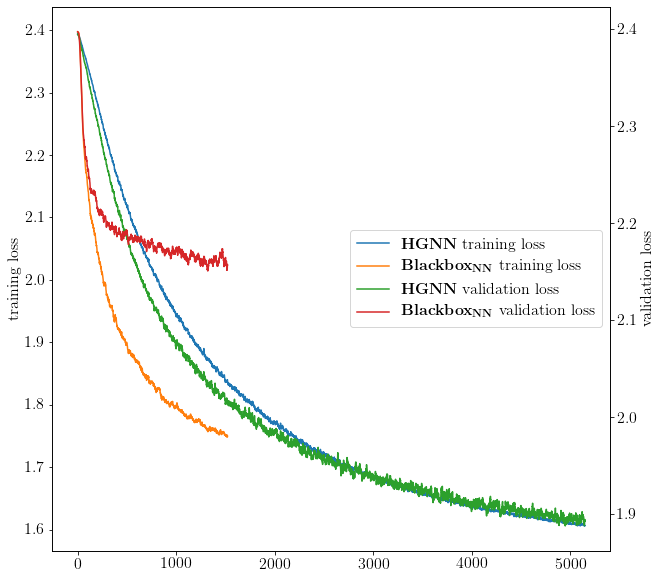

In [91]:
fig,ax = plt.subplots(figsize=(10, 10))



# result.plot(ax=ax, y=[names[0] + ' test accuracy', names[1] + ' test accuracy'])
result.plot(ax=ax, y=[names[0] + ' training loss', names[1] + ' training loss'])
result.plot(ax=ax, y=[names[0] + ' validation loss', names[1] + ' validation loss'], secondary_y=True)

ax.set_ylabel('training loss')
ax.right_ax.set_ylabel('validation loss')

lines = ax.get_lines() + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='center right')

# ax.legend(loc='center right')


# Analysis/Modeling
Do work here

# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here